# Non-Atomic Arbitrage

The following version were used:
- Python version: 3.10.12 [GCC 11.4.0]
- pip: 23.3.1 
- pandas: 2.1.2
- numpy: 1.26.1
- web3: 6.11.2
- matplotlib: 3.8.1
- seaborn: 0.13.0
- scipy: 0.13.0

In [1]:
!pip install pandas==2.1.2
!pip install numpy==1.26.1
!pip install web3==6.11.2
!pip install matplotlib==3.8.1
!pip install seaborn==0.13.0
!pip install scipy==1.11.3
!pip install setuptools
!pip install Jinja2

In [2]:
import pandas as pd
import numpy as np
import os
from web3 import Web3, HTTPProvider
import json
import datetime as dt
import matplotlib.pyplot as plt
from  enum import Enum
import matplotlib.dates as mdates
import matplotlib
import seaborn as sns
from scipy.stats import pearsonr   
import matplotlib.ticker as mticker

In [3]:
MAX_BLOCK_NUMBER = 18473542 #Last block number on 2023-10-31

In [4]:
class Color(Enum):
    LIGHTBLUE = "#06AED5" 
    RED = "#DA3E52" 
    YELLOW = "#F8BE57"
    PURPLE ="#7E6B8F" 
    GREEN = "#02C39A" 
    DARKBLUE = "#05668D"
    VIOLET ='#B118C8'
    ORANGE = '#FF784F'
    ROSE = '#B98389'
    PINK = '#F2BAC9'
    LIGHTGREEN ='#C1CC99'
    DARKPURPLE ='#3c096c'
    LIGHTCYAN = '#D9F7FA'

In [5]:
#helper class to move y axis factor, obtained from https://stackoverflow.com/questions/45760763/how-to-move-the-y-axis-scale-factor-to-the-position-next-to-the-y-axis-label
class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " "+ fmt.get_offset() )    

In [6]:
def currency_format(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e8:
        s = '{:1.1f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '{:1.1f}M'.format(x*1e-6)
    elif x >= 1e3:
        s = '{:1.1f}K'.format(x*1e-3)
    else: 
        s = '{:1.0f}'.format(x)
    return s
def currency_format_int(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e8:
        s = '{:1.0f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '{:1.0f}M'.format(x*1e-6)
    elif x >= 1e3:
        s = '{:1.0f}K'.format(x*1e-3)
    else: 
        s = '{:1.0f}'.format(x)
    return s

## Load Data

Load swap data

In [7]:
swapData =pd.read_pickle('data/swaps/filteredSwapsWithPrice.pkl')
swapData =swapData.replace('0xa69babef1ca67a37ffaf7a485dfff3382056e78c',  "beaversearcher1")
swapData =swapData.replace('0x5050e08626c499411b5d0e0b5af0e83d3fd82edf',  "bot2")
swapData =swapData.replace('0x9507c04b10486547584c37bcbd931b2a4fee9a41',  "jumpsearcher")
swapData =swapData.replace('0x280027dd00ee0050d3f9d168efd6b40090009246',  "rsyncsearcher2")
swapData =swapData.replace('0xf8b721bff6bf7095a0e10791ce8f998baa254fd0',  "mantasearcher")
swapData =swapData.replace('0x0087bb802d9c0e343f00510000729031ce00bf27',  "rsyncsearcher1")#submits to other builders, same bytecode
swapData =swapData.replace('0x51c72848c68a965f66fa7a88855f9f7784502a7f',  "rsyncsearcher3")
swapData =swapData.replace('0x98c3d3183c4b8a650614ad179a1a98be0a8d6b8e',  "searcher5")
swapData =swapData.replace('0xe8cfad4c75a5e1caf939fd80afcf837dde340a69',  "searcher1")
swapData =swapData.replace('0xd7f3fbe8c72a961a5515203eada59750437fa762',  "searcher3")
swapData =swapData.replace('0x57c1e0c2adf6eecdb135bcf9ec5f23b319be2c94',  "builder1searcher")
swapData =swapData.replace('0xbeefbabeea323f07c59926295205d3b7a17e8638',  "bot4")
swapData =swapData.replace('0xa57bd00134b2850b2a1c55860c9e9ea100fdd6cf',  "beaversearcher2")
swapData =swapData.replace('0x00000000008c4fb1c916e0c88fd4cc402d935e7d',  "searcher2")
swapData =swapData.replace('0x000000000dfde7deaf24138722987c9a6991e2d4',  "searcher4")

In [8]:
HFTBuilder =['beaverbuild','rsyncbuilder','mantabuilder','builder1']

Load block data

In [9]:
blockData = pd.read_pickle('data/blocks/blockInfo.pkl')
blockData.drop(columns=['relay'], inplace=True)
blockData.drop_duplicates(keep='first', inplace=True)
blockData.drop(columns=['value','baseFeePerGas'], inplace=True)
blockData.rename(columns={'gasUsed':'gasUsedBlock'}, inplace=True)
blockData['day'] = blockData.time.dt.date
blockData['proposerfee']= blockData['proposerfee'].astype(float).fillna(0)/10**18
blockData['coinbasetransfers']=blockData['coinbasetransfers'].astype(float).fillna(0)/10**18
blockData['proposerpayment']=blockData['proposerpayment'].astype(float).fillna(0)/10**18

Load price data

In [10]:
priceETHDaily =pd.read_pickle('data/price/ETHUSDTdaily.pkl')
priceETHDaily['vol']= np.log(priceETHDaily['High']/priceETHDaily['Low'])
priceBTCDaily =pd.read_pickle('data/price/BTCUSDTdaily.pkl')
priceBTCDaily['vol']=np.log(priceBTCDaily['High']/priceBTCDaily['Low'])

Load time

In [11]:
time=pd.read_csv('data/general/time.csv')
time.rename(columns={'height':'block'},inplace=True)
time.rename(columns={'time_mined':'time'},inplace=True)

Merge data

In [12]:
mergedData=swapData.merge(blockData,left_on='block',right_on='height')
mergedData['day'] = mergedData.time.dt.date

Load MEV data

In [13]:
mevdata=pd.read_pickle('data/general/mevdata.pkl')

# Case Study Block 18,360,789

In [14]:
slot = 7550782
slotStart =slot- slot%1000
slotEnd =slotStart+999
slotEnd2 =slotStart+9999

In [15]:
aestus =pd.read_csv('data/casestudy/builder_blocks_received_aestus_'+str(slotStart)+'_'+str(slotEnd)+'.csv')
aestus=aestus[aestus.slot==slot]
aestus['value']=aestus['value'].astype(float)/10**18

flashbots =pd.read_csv('data/casestudy/builder_blocks_received_flashbots_'+str(slotStart)+'_'+str(slotEnd)+'.csv')
flashbots=flashbots[flashbots.slot==slot]
flashbots['value']=flashbots['value'].astype(float)/10**18

agnostic =pd.read_csv('data/casestudy/builder_blocks_received_agnostic_'+str(slotStart)+'_'+str(slotEnd)+'.csv')
agnostic=agnostic[agnostic.slot==slot]
agnostic['value']=agnostic['value'].astype(float)/10**18

ultrasound =pd.read_csv('data/casestudy/builder_blocks_received_ultrasound_'+str(slotStart)+'_'+str(slotEnd)+'.csv')
ultrasound=ultrasound[ultrasound.slot==slot]
ultrasound['value']=ultrasound['value'].astype(float)/10**18

manifold =pd.read_csv('data/casestudy/builder_blocks_received_manifold_'+str(slotStart)+'_'+str(slotEnd)+'.csv')
manifold=manifold[manifold.slot==slot]
manifold['value']=manifold['value'].astype(float)/10**18

In [16]:
bids = pd.concat([aestus,flashbots,agnostic,ultrasound,manifold])
bids['timestamp_ms'] =pd.to_datetime(bids['timestamp_ms'], unit='ms')
bids = bids.replace("0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3324d61afbdb33a8885ff8cab2ef514ac2c7698ae0d6289ef27fc",  "flashbots")
bids = bids.replace('0x81babeec8c9f2bb9c329fd8a3b176032fe0ab5f3b92a3f44d4575a231c7bd9c31d10b6328ef68ed1e8c02a3dbc8e80f9',  "flashbots")
bids = bids.replace('0x81beef03aafd3dd33ffd7deb337407142c80fea2690e5b3190cfc01bde5753f28982a7857c96172a75a234cb7bcb994f',  "flashbots")
bids = bids.replace('0xb086acdd8da6a11c973b4b26d8c955addbae4506c78defbeb5d4e00c1266b802ff86ec7457c4c3c7c573fa1e64f7e9e0',  "bloxrouteE")
bids = bids.replace('0x95701d3f0c49d7501b7494a7a4a08ce66aa9cc1f139dbd3eec409b9893ea213e01681e6b76f031122c6663b7d72a331b',  "bloxrouteE")
bids = bids.replace('0x82801ab0556f7df1fb9bb3a61ca84beea8285a8dc3c455a7ea16a8b2993fe06058e0e7d275b28ea5d9f2ae995aa72605',  "bloxrouteE")
bids = bids.replace('0x94aa4ee318f39b56547a253700917982f4b737a49fc3f99ce08fa715e488e673d88a60f7d2cf9145a05127f17dcb7c67',  "bloxrouteM")
bids = bids.replace('0x976e63c505050e25b70b39238990c78ddf0948685eb8c5687d17ba5089541f37dd3c45999f2db449eac298b1d4856013',  "bloxrouteM")
bids = bids.replace('0x8b8edce58fafe098763e4fabdeb318d347f9238845f22c507e813186ea7d44adecd3028f9288048f9ad3bc7c7c735fba',  "bloxrouteM")
bids = bids.replace('0xafc9274fe595e8cff421ab9e73b031f0dff707ea1852e2233ff070ef18e3876e25c44a9831c4b5f802653d4678ccc31f',  "bloxrouteM")
bids = bids.replace('0xaa1488eae4b06a1fff840a2b6db167afc520758dc2c8af0dfb57037954df3431b747e2f900fe8805f05d635e9a29717b',  "bloxrouteM")
bids = bids.replace('0x80c7311597316f871363f8395b6a8d056071d90d8eb27defd14759e8522786061b13728623452740ba05055f5ba9d3d5',  "bloxrouteR")
bids = bids.replace('0xb9b50821ec5f01bb19ec75e0f22264fa9369436544b65c7cf653109dd26ef1f65c4fcaf1b1bcd2a7278afc34455d3da6',  "bloxrouteR")
bids = bids.replace('0x965a05a1ba338f4bbbb97407d70659f4cea2146d83ac5da6c2f3de824713c927dcba706f35322d65764912e7756103e2',  "bloxrouteR")
bids = bids.replace('0xa1daf0ab37a9a204bc5925717f78a795fa2812f8fba8bda10b1b27c554bd7dedd46775106facd72be748eea336f514e9',  "builder1")
bids = bids.replace('0x89783236c449f037b4ad7bae18cea35014187ec06e2daa016128e736739debeafc5fe8662a0613bc4ca528af5be83b3c',  "builder1")
bids = bids.replace('0xb194b2b8ec91a71c18f8483825234679299d146495a08db3bf3fb955e1d85a5fca77e88de93a74f4e32320fc922d3027',  "builder0x69")
bids = bids.replace('0xa971c4ee4ac5d47e0fb9e16be05981bfe51458f14c06b7a020304099c23d2d9952d4254cc50f291c385d15e7cae0cf9d',  "builder0x69")
bids = bids.replace('0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d053be613f469a48f7416999a4da35dd60a7824478661399e6772',  "builder0x69")
bids = bids.replace('0xb8fceec09779ff758918a849bfe8ab43cea79f6a98320af0af5b030f6a7850fcc5883cb965d02efb10eed1ffa987e899',  "builder0x69")
bids = bids.replace('0x8bc8d110f8b5207e7edc407e8fa033937ddfe8d2c6f18c12a6171400eb6e04d49238ba2b0a95e633d15558e6a706fbe4',  "builder0x69")
bids = bids.replace('0xb5d883565500910f3f10f0a2e3a031139d972117a3b67da191ff93ba00ba26502d9b65385b5bca5e7c587273e40f2319',  "beaverbuild")
bids = bids.replace('0x96a59d355b1f65e270b29981dd113625732539e955a1beeecbc471dd0196c4804574ff871d47ed34ff6d921061e9fc27',  "beaverbuild")
bids = bids.replace('0x8dde59a0d40b9a77b901fc40bee1116acf643b2b60656ace951a5073fe317f57a086acf1eac7502ea32edcca1a900521',  "beaverbuild")
bids = bids.replace('0xaec4ec48c2ec03c418c599622980184e926f0de3c9ceab15fc059d617fa0eafe7a0c62126a4657faf596a1b211eec347',  "beaverbuild")
bids = bids.replace('0x8000008a03ebae7d8ab2f66659bd719a698b2e74097d1e423df85e0d58571140527c15052a36c19878018aaebe8a6fea',  "blocknative")
bids = bids.replace('0x9000009807ed12c1f08bf4e81c6da3ba8e3fc3d953898ce0102433094e5f22f21102ec057841fcb81978ed1ea0fa8246',  "blocknative")
bids = bids.replace('0xa66f3abc04df65c16eb32151f2a92cb7921efdba4c25ab61b969a2af24b61508783ceb48175ef252ec9f82c6cdf8d8fd',  "blocknative")
bids = bids.replace('0xa00000a975dffbd1ef61953ac6c90b52b70eb0188eb9d030774346c9248f81e875f7e8bc56c4bbbda297a9543cfa051d',  "blocknative")
bids = bids.replace('0x8e39849ceabc8710de49b2ca7053813de18b1c12d9ee22149dac4b90b634dd7e6d1e7d3c2b4df806ce32c6228eb70a8b',  "eden")
bids = bids.replace('0xa5eec32c40cc3737d643c24982c7f097354150aac1612d4089e2e8af44dbeefaec08a11c76bd57e7d58697ad8b2bbef5',  "eden")
bids = bids.replace('0x91970c2db7c12510acb2e9c45844f7de602f83a7f31064f7ca04a807b607d7aebfc0abda73c036a92e5c3e56ebca04b7',  "eden")
bids = bids.replace('0xa412007971217a42ca2ced9a90e7ca0ddfc922a1482ee6adf812c4a307e5fb7d6e668a7c86e53663ddd53c689aa3d350',  "eden")
bids = bids.replace('0x82ba7cadcdfc1b156ba2c48c1c627428ba917858e62c3a97d8f919510da23d0f11cf5db53cb92a5faf5de7d31bf38632',  "buildAI")
bids = bids.replace('0xa1f10d66aa4b73c5d9a6cc38a098b2c6ce031a6750ea2da01918ba3ac57c2ce1e39a0da622bd8ccd7c9930861f949fa2',  "FC")
bids = bids.replace('0x8bcd1148e83d0a844d2d42f90df0837dbe407055367b3bfcf04227e47ea65a0164fc13a66584aae286f8f7322dc69501',  "builder2")
bids = bids.replace('0xa25f5d5bd4f1956971bbd6e5a19e59c9b1422ca253587bbbb644645bd2067cc08fb854a231061f8c91f110254664e943',  "manifold")
bids = bids.replace('0xa0d0dbdf7b5eda08c921dee5da7c78c34c9685db3e39e81eb91da94af29eaa50f1468813c86503bf41b4b51bf772800e',  "mantabuilder")
bids = bids.replace('0xb1b734b8dd42b4744dc98ea330c3d9da64b7afc050afed96875593c73937d530a773e35ddc4b480f9d2e1d5ba452a469',  "mantabuilder")
bids = bids.replace('0xb5a688d26d7858b38c44f44568d68fb94f112fc834cd225d32dc52f0277c2007babc861f6f157a6fc6c1dc25bf409046',  "mantabuilder")
bids = bids.replace('0x8eb772d96a747ba63af7acdf92dc775a859f76a77e4c6ed124dca6360e74e4e798a75a925eb8fd0dde866317fff18ad0',  "ethbuilder")
bids = bids.replace('0x8ea1393f49d894ae22ec86e38d9aeb64b8336dac947e69cb8468acf510d010ce0b51b21ac3e1244bdb91c52e020ea525',  "ethbuilder")
bids = bids.replace('0x945fc51bf63613257792926c9155d7ae32db73155dc13bdfe61cd476f1fd2297b66601e8721b723cef11e4e6682e9d87',  "rsyncbuilder")
bids = bids.replace('0x83d3495a2951065cf19c4d282afca0a635a39f6504bd76282ed0138fe28680ec60fa3fd149e6d27a94a7d90e7b1fb640',  "rsyncbuilder")
bids = bids.replace('0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4d86ea463d712af1dc80131d0c650dc29ba29ef27c881f43bd587',  "rsyncbuilder")
bids = bids.replace('0x94a076b27f294dc44b9fd44d8e2b063fb129bc85ed047da1cefb82d16e1a13e6b50de31a86f5b233d1e6bbaca3c69173',  "titanbuilder")
bids = bids.replace('0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08',  "titanbuilder")
bids = bids.replace('0xacb407cfb554255db2fbbb320f79bb7f1cc1e8d2dc43324e8e31baafd0836340d49c43eebc51828f53bf6d364f9ac207',  "beaverbuild")
bids = bids.replace('0xb26f96664274e15fb6fcda862302e47de7e0e2a6687f8349327a9846043e42596ec44af676126e2cacbdd181f548e681',  "titanbuilder")
bids = bids.replace('0xacfdcf458829f4693168a57d0659253069d687682bc64ec130d935ecb6e05ccfb80c138bd3cf53546c86715696612ec8',  "rsyncbuilder")
bids = bids.replace('0xabc387dff20ff4bda974b7f3041ea857d591681cc03271519196587a2d6b30c953ea4df11acf637db76f462834a8c80e',  "f1b")
bids = bids.replace('0x8aab0ed724d2c7f94af139bd2249ab511f08474ac69e761e56918403c81c358f5f8a6d61c62a86dc4cd7bcad935f49d9',  "rsyncbuilder")
bids = bids.replace('0x8e6df6e0a9ca3fd89db2aa2f3daf77722dc4fbcd15e285ed7d9560fdf07b7d69ba504add4cc12ac999b8094ff30ed06c',  "rsyncbuilder")
bids = bids.replace('0xb89b9308fbc6c2998c7e60e39424b858c74b02c234b3e0fa5ecf7c3971208dfa5f92e0bdbe16fc24abfd71c248acf0f9',  "flashbotsimposter")
bids = bids.replace('0xae7f0dd473d986b277539cca610aba02c437082ac504b998079edf20b0258db6cc6f6f27220d6428283691db53e62c3b',  "gambitlabs")
bids = bids.replace('0xab847befe59b5effffa12f47acf44cbf8ef875e7c891a4ee9e9c483254cf9a55f5ed688e43ff5bc6cd9276e99091921b',  "bobabuilder")
bids = bids.replace('0x95c8cc31f8d4e54eddb0603b8f12d59d466f656f374bde2073e321bdd16082d420e3eef4d62467a7ea6b83818381f742',  "titanbuilder")
bids = bids.replace('0xa21a2f4807a2bcb6b07c10cea241322e0910c30869c1e4eda686b0d69bdcb74d2a140ef994afcf0bb38e0b960df4d2ee',  "beaverbuild")
bids = bids.replace('0x8ed74896fb129ac7f48d6a2908400044103b65d5c4e8f63feafd849f90fc174a4b71206a51b9453c12292bab3a92a4a2',  "ethbuilder")
bids = bids.replace('0x83bee51799e65130296f5d60ce7d78119578db6045c3c3631980514abae0be0f9b65fe82eb0c9a79d6d99030112c874c',  "builder3")
bids = bids.replace('0x81babad2d5fd9413c942f49bfd86bc1dca5b02ff4cd065a10c7ab05713e63883056e6a87777e236424574aa25bbe3e99',  "flashbotsimposter")
bids = bids.replace('0x84b02bdb674a28dea0467d3dded2b4aad11c0c5dba79b3d11c38476e2f45eb937ac078492781cca8d2123c2c574a7eb8',  "lightspeedbuilder")
bids = bids.replace('0xb3a4b137b0224321813151568035e4c0dd7af8a2523a606a73b7d459a6202e7d6d58f2149a32bc2fe85980866fdc0c92',  "lightspeedbuilder")
bids = bids.replace('0x89551cb5def7a710d58c3f3c0b234266df9cab138d6bd79e58b03c3681030751f1aab2e2b08a706e2aba6db23ee1fb8b',  "payload")
bids = bids.replace('0xb193dcaf1d485ba78094cb6b4126bff77e08c1244dff814447d3a31d9030b2584b369244ea67f13d48a02fa907b05f3a',  "blockbeelder")
bids = bids.replace('0x987ff80fcf6c5ee530f4a4352884cb89fc5f57ab287e58dd44d641f3bbe4cc40633d6ba0bbecc9c81b1d5be40a2abb99',  "bobthebuilder")
bids = bids.replace('0x91afe2631915f3fbd83f1d75e13ae8597b593441344bb55bf542b9bac31f662d1c820cafe4cde17291f115bb68a9945a',  "bobthebuilder")
bids = bids.replace('0x8070d2fbed08a3f251189cf304b5aa4de1c6817189e6779fa91bfed92a54c14ad81a86e3860040a36cbe6225ad5961e2',  "payload")
bids = bids.replace('0xac193b0f72fa96fab3695697f01a27441fdc70fe38bc6ad1eb4fd887f84025eb1708cd1678b6b4d7a63cc62039845251',  "payload")
bids = bids.replace('0x85b603e6b0b27e117e80c67a615060b3d0441ae2aee163cc49f30c964155e46fbd324b25c0fbadf9f4995a4b8b245be3',  "payload")
bids = bids.replace('0x8d0187110022b21a97a265d9b98aae51cdd563e53ceacb6ca9ebd0dcdac91866a52aff73836d95ef1e587591291abb02',  "manifold")
bids = bids.replace('0xb052beae829c5b6ea991bfe09960caad5b78dd9c1be18a477fb0121e47e8a89ce6364edc580a72b91106dbfbcb5f80c0',  "freerealestate")

In [17]:
ETHUSDTBlock=pd.read_csv('data/casestudy/ETHUSDT-aggTrades-2023-10-16.zip',names=['price','quantity','first_trade_id','last_trade_id','time','is_buyer_maker','todo'])
ETHUSDTBlock['time'] = pd.to_datetime(ETHUSDTBlock['time'], unit='ms')
ETHUSDTBlock = ETHUSDTBlock[(ETHUSDTBlock.time>bids.timestamp_ms.min())&( ETHUSDTBlock.time<bids.timestamp_ms.max())]
ETHUSDTBlock['price'] = (ETHUSDTBlock['price']/ETHUSDTBlock['price'].iloc[0]-1)*100

BTCUSDTBlock=pd.read_csv('data/casestudy/BTCUSDT-aggTrades-2023-10-16.zip',names=['price','quantity','first_trade_id','last_trade_id','time','is_buyer_maker','todo'])
BTCUSDTBlock['time'] = pd.to_datetime(BTCUSDTBlock['time'], unit='ms')
BTCUSDTBlock = BTCUSDTBlock[(BTCUSDTBlock.time>bids.timestamp_ms.min())&( BTCUSDTBlock.time<bids.timestamp_ms.max())]
BTCUSDTBlock['price'] = (BTCUSDTBlock['price']/BTCUSDTBlock['price'].iloc[0] -1)*100

In [18]:
plt.rcParams["figure.figsize"] = (3.4,1.8) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

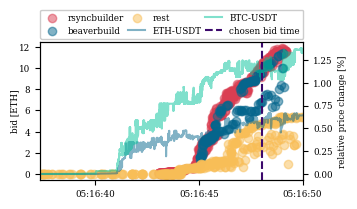

In [19]:
ax =plt.gca()

ln2=ax.scatter(bids[bids.builder_pubkey=='rsyncbuilder'].timestamp_ms, bids[bids.builder_pubkey=='rsyncbuilder'].value,label='rsyncbuilder',marker='o',color=Color.RED.value,alpha=0.5)
ln1=ax.scatter(bids[bids.builder_pubkey=='beaverbuild'].timestamp_ms, bids[bids.builder_pubkey=='beaverbuild'].value,label='beaverbuild',marker='o',color=Color.DARKBLUE.value,alpha=0.5)
ln3=ax.scatter(bids[(bids.builder_pubkey!='rsyncbuilder')&(bids.builder_pubkey!='beaverbuild')].timestamp_ms, bids[(bids.builder_pubkey!='rsyncbuilder')&(bids.builder_pubkey!='beaverbuild')].value,label='rest',marker='o',color=Color.YELLOW.value,alpha=0.5)

ax2= ax.twinx()

ln4=ax2.plot(ETHUSDTBlock.time, ETHUSDTBlock.price,label='ETH-USDT', color=Color.DARKBLUE.value,alpha=0.5)
ln5=ax2.plot(BTCUSDTBlock.time, BTCUSDTBlock.price,label='BTC-USDT',color=Color.GREEN.value,alpha=0.5)

ln6=plt.axvline(x=bids[bids.block_hash =='0x6facc218ccdd8f36b901374c6ff66b01896c2c1d3097cf7e07011568f672ceee'].timestamp_ms.values[0], color=Color.DARKPURPLE.value, linestyle='--',label='chosen bid time')

plt.xlim(bids.timestamp_ms.min(),bids.timestamp_ms.max())
ax.yaxis.labelpad=0
ax.set_ylabel('bid [ETH]')
ax2.set_ylabel('relative price change [%]')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lgd =ax2.legend(lines + lines2, labels + labels2, facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)
plt.show()

In [20]:
table =mergedData[mergedData.height==18360789].sort_values(by='indexInBlock')[['indexInBlock','recipient','pool','tokenIn','tokenOut','amountUSD']]
table['pool'] = table['pool'].str[:7]+'...'+table['pool'].str[-5:]

In [21]:
print(table.to_latex(index=False,float_format="%.3f"))

\begin{tabular}{rlllll}
\toprule
indexInBlock & recipient & pool & tokenIn & tokenOut & amountUSD \\
\midrule
0 & rsyncsearcher3 & 0x88e6a...f5640 & USDC & ETH & 2148195.308 \\
1 & rsyncsearcher3 & 0x99ac8...abc35 & USDC & BTC & 659507.701 \\
2 & rsyncsearcher3 & 0x4585f...a20c0 & ETH & BTC & 554524.411 \\
3 & rsyncsearcher3 & 0x9db9e...8425b & USDT & BTC & 186858.044 \\
4 & rsyncsearcher3 & 0x11b81...697f6 & USDT & ETH & 523225.597 \\
5 & rsyncsearcher3 & 0x4e68c...dfa36 & USDT & ETH & 524150.487 \\
6 & rsyncsearcher3 & 0xcbcdf...d62ed & ETH & BTC & 495617.185 \\
8 & searcher1 & 0x8ad59...6e6d8 & USDC & ETH & 562787.652 \\
9 & rsyncsearcher3 & 0x60594...5a270 & DAI & ETH & 116090.952 \\
10 & rsyncsearcher3 & 0xc2e9f...a25f8 & DAI & ETH & 105871.055 \\
12 & searcher1 & 0xd51a4...aae46 & USDT & BTC & 17463.007 \\
14 & rsyncsearcher3 & 0x391e8...86649 & DAI & BTC & 9214.814 \\
17 & rsyncsearcher3 & 0x06da0...84553 & USDT & ETH & 18283.993 \\
18 & rsyncsearcher3 & 0xc3d03...5882f & DAI & 

In [22]:
print("Payment to proposer in block 18,360,789: ",float(blockData[blockData.height==18360789].proposerpayment.iloc[0])/10**18, " ETH")

Payment to proposer in block 18,360,789:  1.0320549698079668e-17  ETH


# Data Analysis 

Identify big bots and builder taking part

In [24]:
bigBots=mergedData.groupby('recipient').agg({'amountUSD':'sum'}).sort_values(by='amountUSD', ascending=False).head(11).index
bigBuilders =mergedData.groupby('builderPubkey').agg({'amountUSD':'sum'}).sort_values(by='amountUSD', ascending=False).head(9).index
bigBuilders=bigBuilders.tolist()+['rest']
bigBots=bigBots.tolist()+['rest']
mergedData['recipient'] = np.where((~mergedData['recipient'].isin(bigBots)), 'rest', mergedData['recipient'])
mergedData['builderPubkey'] = np.where((~mergedData['builderPubkey'].isin(bigBuilders)), 'rest', mergedData['builderPubkey'])
blockData['builderPubkey'] = np.where(((~blockData['builderPubkey'].isin(bigBuilders))&(blockData['builderPubkey']==blockData['builderPubkey'])), 'rest', blockData['builderPubkey'])

In [25]:
print("Non-atomic arbitrage volume: ",mergedData.amountUSD.sum()/10**9," billion $")

Non-atomic arbitrage volume:  132.1993127110411  billion $


In [26]:
print('Share of non-atomic arbitrage volume by top 4 searchers: ',mergedData[mergedData.recipient.isin(bigBots[:3])].amountUSD.sum()/mergedData.amountUSD.sum())

Share of non-atomic arbitrage volume by top 4 searchers:  0.4921861562649755


In [27]:
print('Share of non-atomic arbitrage volume by top 11 searchers: ',mergedData[mergedData.recipient.isin(bigBots[:-1])].amountUSD.sum()/mergedData.amountUSD.sum())

Share of non-atomic arbitrage volume by top 11 searchers:  0.8084683973376632


## Swap Size by Searcher

In [28]:
my_pal = {bigBots[0]: Color.DARKBLUE.value,bigBots[1]: Color.GREEN.value,bigBots[2]: Color.YELLOW.value,bigBots[3]: Color.RED.value,bigBots[4]: Color.DARKPURPLE.value,
            bigBots[5]: Color.PINK.value,bigBots[6]: Color.LIGHTBLUE.value,bigBots[7]: Color.LIGHTGREEN.value,bigBots[8]: Color.ORANGE.value,bigBots[9]: Color.VIOLET.value,bigBots[10]: Color.ROSE.value,bigBots[10]: Color.PURPLE.value,bigBots[11]: Color.LIGHTCYAN.value}

In [29]:
plt.rcParams["figure.figsize"] = (8.2,1.8) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

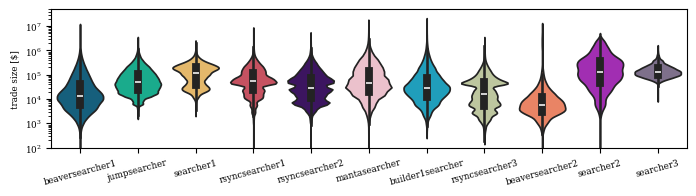

In [30]:
ax =plt.gca()
sns.violinplot(x=swapData[swapData.recipient.isin(bigBots[:-1])]['recipient'], 
               y=swapData[swapData.recipient.isin(bigBots[:-1])]['amountUSD'],
               order = bigBots[:-1],
               hue=swapData[swapData.recipient.isin(bigBots[:-1])]['recipient'],
               ax=ax, log_scale=True, 
               palette=my_pal,legend=False)
plt.ylim(100, 50000000)
#plt.xticks(rotation=25, ha='right')
plt.ylabel('trade size [$]')
plt.xlabel('')
plt.xticks(rotation=15, ha='center')
plt.show()

In [31]:
print("Mean trade size :",swapData[swapData.recipient.isin(bigBots[:-1])].amountUSD.mean()," $")

Mean trade size : 73894.43163302122  $


In [32]:
for i in bigBots[:-1]:
    print("Mean trade size",i,swapData[swapData.recipient==i].amountUSD.mean()," $")

Mean trade size beaversearcher1 54356.96621017959  $
Mean trade size jumpsearcher 94558.28020576674  $
Mean trade size searcher1 147507.19670270119  $
Mean trade size rsyncsearcher1 97481.99134866364  $
Mean trade size rsyncsearcher2 68525.49418648136  $
Mean trade size mantasearcher 136484.46881907425  $
Mean trade size builder1searcher 88856.37342429407  $
Mean trade size rsyncsearcher3 41616.94223770027  $
Mean trade size beaversearcher2 49802.51048988431  $
Mean trade size searcher2 317323.39551196835  $
Mean trade size searcher3 161582.50435645063  $


In [33]:
topTokens ={}
for i in bigBots[:-1]:
    topTokens[i]={}
for i in bigBots[:-1]:
    topTokens[i]['proportion of volume']=  swapData[(swapData.recipient==i)&(swapData.tokenIn.isin(['USDC','USDT','DAI','ETH','WBTC']))&(swapData.tokenIn.isin(['USDC','USDT','DAI','ETH','WBTC']))].amountUSD.sum()/swapData[swapData.recipient==i].amountUSD.sum()
for i in bigBots[:-1]:
    topTokens[i]['proportion of trades']=swapData[(swapData.recipient==i)&(swapData.tokenIn.isin(['USDC','USDT','DAI','ETH','WBTC']))&(swapData.tokenIn.isin(['USDC','USDT','DAI','ETH','WBTC']))].size/swapData[swapData.recipient==i].size

In [34]:
tableTopTokens=pd.DataFrame.from_dict(topTokens, orient='index').T
print(tableTopTokens.to_latex(index=True,float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & beaversearcher1 & jumpsearcher & searcher1 & rsyncsearcher1 & rsyncsearcher2 & mantasearcher & builder1searcher & rsyncsearcher3 & beaversearcher2 & searcher2 & searcher3 \\
\midrule
proportion of volume & 0.916 & 0.901 & 0.943 & 0.922 & 0.898 & 0.936 & 0.810 & 0.855 & 0.950 & 0.974 & 1.000 \\
proportion of trades & 0.704 & 0.865 & 0.874 & 0.867 & 0.721 & 0.814 & 0.661 & 0.673 & 0.659 & 0.890 & 1.000 \\
\bottomrule
\end{tabular}



## Market Share by Searcher

In [35]:
plt.rcParams["figure.figsize"] = (3.7,2) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

In [36]:
print("Proportion of volume in PBS blocks: ",mergedData[mergedData.PBSBlock==1].amountUSD.sum()/mergedData.amountUSD.sum())

Proportion of volume in PBS blocks:  0.989810044015312


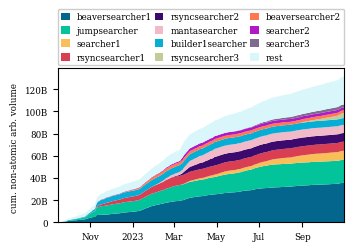

In [37]:

df = pd.DataFrame(mergedData.groupby(['recipient','day']).agg({'amountUSD':'sum'}).reset_index(), columns=['recipient', 'day', 'amountUSD'])\
    .set_index('day')\
    .sort_values('day')

pt = pd.pivot_table(df, columns=['recipient'], index=['day'], values=['amountUSD'], fill_value=0)
pt.columns = pt.columns.droplevel()
pt =pt[bigBots]
pt = pt.cumsum()
pt.plot.area(linewidth=0,color=my_pal)
ax =plt.gca()

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   


ax.yaxis.set_major_formatter(currency_format_int)   
lo = Labeloffset(ax, label=r"cum. non-atomic arb. volume", axis="y")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.,handleheight=1, handlelength=1)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.xlabel('')
plt.show()

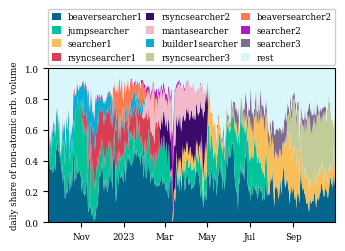

In [38]:

blockPerBot=mergedData.copy()

blockPerBot=blockPerBot.groupby(['day', 'recipient']).amountUSD.sum().unstack(fill_value=0)
blockPerBot['sum']=blockPerBot.sum(axis=1)
blockPerBot.iloc[:,:-1]=blockPerBot.iloc[:,:-1].div(blockPerBot.iloc[:,-1], axis=0)

blockPerBot['rest'] = blockPerBot.pop('rest')
blockPerBot=blockPerBot[bigBots]

ax = blockPerBot.plot.area(linewidth=0,color=my_pal)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
plt.xlabel('')
plt.ylabel('daily share of non-atomic arb. volume')
plt.ylim(0,1)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.,handleheight=1, handlelength=1)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [39]:
dataNakamoto=blockPerBot.drop(columns=['rest'])
dictNakamoto = {}
for i in range(len(dataNakamoto)):
    dictNakamoto[i] =sorted(dataNakamoto.iloc[i, :].values.tolist(), reverse=True)
tempDF = pd.DataFrame.from_dict(dictNakamoto).T
tempDF.index = dataNakamoto.index
dataNakamoto = tempDF
dataNakamoto=dataNakamoto.cumsum(axis=1)


In [40]:
dataNakamotoPoW=blockPerBot.drop(columns=['rest'])
dictNakamotoPoW = {}
for i in range(len(dataNakamotoPoW)):
    dictNakamotoPoW[i] =sorted(dataNakamotoPoW.iloc[i, :].values.tolist(), reverse=True)
tempDF = pd.DataFrame.from_dict(dictNakamotoPoW).T
tempDF.index = dataNakamotoPoW.index
dataNakamotoPoW = tempDF
dataNakamotoPoW=dataNakamotoPoW.cumsum(axis=1)

In [41]:
def nakamoto50(series):
    return len(series[series <= 0.50]) + 1
nakamoto =dataNakamoto.apply(nakamoto50, axis=1)

In [42]:
len(nakamoto[nakamoto<=1])/len(nakamoto)

0.024271844660194174

In [43]:
plt.rcParams["figure.figsize"] = (3.3,2) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

## Correlation with Volatility

Non-atomic arbitrage volume

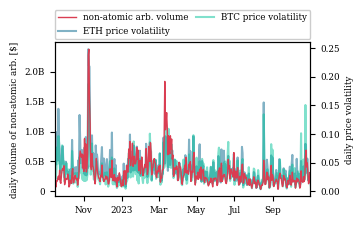

In [44]:
ax =plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
ax2 = ax.twinx()
ln2=ax2.plot(priceETHDaily.vol, color=Color.DARKBLUE.value,alpha=0.5,label='ETH price volatility')
ln3=ax2.plot(priceBTCDaily.vol, color=Color.GREEN.value,alpha=0.5,label='BTC price volatility')
ln1=ax.plot(mergedData.groupby('day').amountUSD.sum(), color=Color.RED.value,label='non-atomic arb. volume',linewidth =1)
#ax2.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('daily volume of non-atomic arb. [$]')
ax.yaxis.set_major_formatter(currency_format)

ax2.set_ylabel('daily price volatility')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [45]:
print(pearsonr((mergedData.groupby('day').amountUSD.sum()).tolist(),priceBTCDaily.loc['2022-09-15':'2023-10-31'].vol.tolist()))

PearsonRResult(statistic=0.724568029171988, pvalue=2.8619698394748413e-68)


In [46]:
print(pearsonr((mergedData.groupby('day').amountUSD.sum()).tolist(),priceETHDaily.loc['2022-09-15':'2023-10-31'].vol.tolist()))

PearsonRResult(statistic=0.7294492794852757, pvalue=1.2985350788866747e-69)


HFT builder blocks

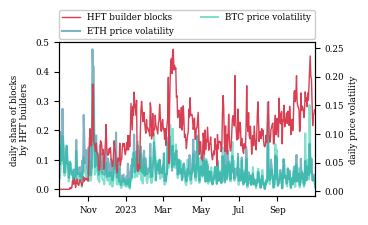

In [47]:
ax =plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
ax2 = ax.twinx()
ln2=ax2.plot(priceETHDaily.vol, color=Color.DARKBLUE.value,alpha=0.5,label='ETH price volatility')
ln3=ax2.plot(priceBTCDaily.vol, color=Color.GREEN.value,alpha=0.5,label='BTC price volatility')
ln1=ax.plot(mergedData[mergedData['builderPubkey'].isin(HFTBuilder)].groupby('day').block.nunique().reindex(pd.date_range(start='2022-09-15', end='2023-10-31')).fillna(0)/blockData.groupby('day').size(), color=Color.RED.value,label='HFT builder blocks',linewidth =1)
#ax2.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('daily share of blocks \nby HFT builders')
ax2.set_ylabel('daily price volatility')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [48]:
print(pearsonr(mergedData[mergedData['builderPubkey'].isin(HFTBuilder)].groupby('day').block.nunique().reindex(pd.date_range(start='2023-10-01', end='2023-10-31')).fillna(0)/blockData.groupby('day').size().reindex(pd.date_range(start='2023-10-01', end='2023-10-31')),priceETHDaily.loc['2023-10-01':'2023-10-31'].vol.tolist()))

PearsonRResult(statistic=0.7837238798673881, pvalue=1.8462547335508137e-07)


In [49]:
print(pearsonr(mergedData[mergedData['builderPubkey'].isin(HFTBuilder)].groupby('day').block.nunique().reindex(pd.date_range(start='2023-10-01', end='2023-10-31')).fillna(0)/blockData.groupby('day').size().reindex(pd.date_range(start='2023-10-01', end='2023-10-31')),priceBTCDaily.loc['2023-10-01':'2023-10-31'].vol.tolist()))

PearsonRResult(statistic=0.6502572024473431, pvalue=7.504144989355102e-05)


Weekday and hour volume

In [50]:
plt.rcParams["figure.figsize"] = (3.7,2) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

In [51]:
swapData=swapData.merge(time,on='block',  how='left')

In [52]:
swapData['Weekday'] = pd.to_datetime(swapData.time).dt.dayofweek #.dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
swapData['Hour'] =pd.to_datetime(swapData.time).dt.hour

In [53]:
swapData['Weekday'].replace(0,  "Monday",inplace=True)
swapData['Weekday'].replace(1,  "Tuesday",inplace=True)
swapData['Weekday'].replace(2,  "Wednesday",inplace=True)
swapData['Weekday'].replace(3,  "Thursday",inplace=True)
swapData['Weekday'].replace(4,  "Friday",inplace=True)
swapData['Weekday'].replace(5,  "Saturday",inplace=True)
swapData['Weekday'].replace(6,  "Sunday",inplace=True)

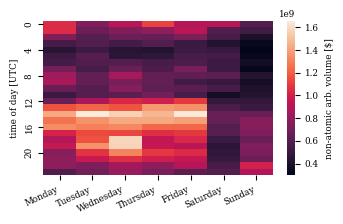

In [54]:
out = swapData.groupby(['Hour', 'Weekday'])['amountUSD'].sum().unstack()
out['Monday'] = out['Monday'].astype(float)
out['Tuesday'] = out['Tuesday'].astype(float)
out['Wednesday'] = out['Wednesday'].astype(float)
out['Thursday'] = out['Thursday'].astype(float)
out['Friday'] = out['Friday'].astype(float)
out['Saturday'] = out['Saturday'].astype(float)
out['Sunday'] = out['Sunday'].astype(float)
sns.heatmap(out[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']], cbar_kws={'label': 'non-atomic arb. volume [$]'},yticklabels = 4)
plt.xlabel('')
plt.ylabel('time of day [UTC]')
plt.xticks(rotation=25, ha='right')

plt.show()

In [55]:
swapData['payment']=(swapData['gasUsed'].astype('float').fillna(0)*swapData['priorityFee'].astype('float').fillna(0)+swapData['value'].astype('float').fillna(0))/10**18

Block size

In [56]:
plt.rcParams["figure.figsize"] = (3.2,1.4) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

In [57]:
blockData1=blockData.merge(mergedData.groupby('block').gasUsed.sum().to_frame().rename(columns={'gasUsed':'gasUsedHFT'}),how='left',left_on='height',right_index=True)
blockData1['gasUsedHFT']=blockData1['gasUsedHFT'].fillna(0)
blockData1['gasUsedHFT']=blockData1['gasUsedHFT']/blockData1['gasUsedBlock']

In [58]:
blockDataETHVol11= blockData1[blockData1['volETH']>blockData1.volETH.quantile(0.99)][['gasUsedHFT','gasUsedBlock']]
blockDataBTCVol11= blockData1[blockData1['volBTC']>blockData1.volETH.quantile(0.99)][['gasUsedHFT','gasUsedBlock']]
blockDataETHVol12= blockData1[blockData1['volETH']>blockData1.volETH.quantile(0.999)][['gasUsedHFT','gasUsedBlock']]
blockDataBTCVol12= blockData1[blockData1['volBTC']>blockData1.volETH.quantile(0.999)][['gasUsedHFT','gasUsedBlock']]
blockDataETHVol1= blockData1[blockData1['volETH']>blockData1.volETH.quantile(0.9)][['gasUsedHFT','gasUsedBlock']]
blockDataBTCVol1= blockData1[blockData1['volBTC']>blockData1.volETH.quantile(0.9)][['gasUsedHFT','gasUsedBlock']]

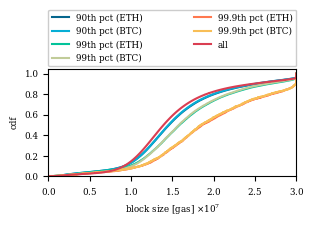

In [59]:
stat = "proportion" 
sns.ecdfplot(blockDataETHVol1['gasUsedBlock'], stat=stat,label='90th pct (ETH)',color=Color.DARKBLUE.value)
sns.ecdfplot(blockDataBTCVol1['gasUsedBlock'], stat=stat,label='90th pct (BTC)',color=Color.LIGHTBLUE.value)
sns.ecdfplot(blockDataETHVol11['gasUsedBlock'], stat=stat,label='99th pct (ETH)',color=Color.GREEN.value)
sns.ecdfplot(blockDataBTCVol11['gasUsedBlock'], stat=stat,label='99th pct (BTC)',color=Color.LIGHTGREEN.value)
sns.ecdfplot(blockDataETHVol12['gasUsedBlock'], stat=stat,label='99.9th pct (ETH)',color=Color.ORANGE.value)
sns.ecdfplot(blockDataBTCVol12['gasUsedBlock'], stat=stat,label='99.9th pct (BTC)',color=Color.YELLOW.value)
sns.ecdfplot(blockData1['gasUsedBlock'], stat=stat,label='all',color=Color.RED.value)
plt.xlabel('block size [gas]')
plt.ylabel('cdf')
plt.xlim(0,3*10**7)
plt.ylim(0,1.05)
ax = plt.gca()
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,3))
ax.xaxis.set_major_formatter(formatter)   
lo = Labeloffset(ax, label=r"block size [gas]", axis="x")

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.show()

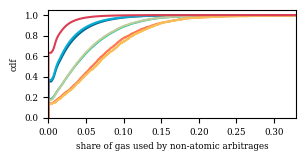

In [60]:
stat = "proportion"  
sns.ecdfplot(blockDataETHVol1['gasUsedHFT'], stat=stat,label='90th pct (ETH)',color=Color.DARKBLUE.value)
sns.ecdfplot(blockDataBTCVol1['gasUsedHFT'], stat=stat,label='90th pct (BTC)',color=Color.LIGHTBLUE.value)
sns.ecdfplot(blockDataETHVol11['gasUsedHFT'], stat=stat,label='99th pct (ETH)',color=Color.GREEN.value)
sns.ecdfplot(blockDataBTCVol11['gasUsedHFT'], stat=stat,label='99th pct (BTC)',color=Color.LIGHTGREEN.value)
sns.ecdfplot(blockDataETHVol12['gasUsedHFT'], stat=stat,label='99.9th pct (ETH)',color=Color.ORANGE.value)
sns.ecdfplot(blockDataBTCVol12['gasUsedHFT'], stat=stat,label='99.9th pct (BTC)',color=Color.YELLOW.value)
sns.ecdfplot(blockData1['gasUsedHFT'], stat=stat,label='all',color=Color.RED.value)
plt.xlabel('share of gas used by non-atomic arbitrages')
plt.ylabel('cdf')
plt.xlim(0,0.33)
plt.ylim(0,1.05)
ax = plt.gca()
plt.show()

Block value

In [61]:
mergedData['txValue']=(mergedData['priorityFee'].fillna(0).astype(float)*mergedData['gasUsed'].fillna(0).astype(float)+mergedData['value'].fillna(0).astype(float))/10**18

In [62]:
blockData2=blockData.merge(mergedData.groupby('block').txValue.sum().to_frame().rename(columns={'txValue':'txValueHFT'}),how='left',left_on='height',right_index=True)
blockData2['txValueHFT']=blockData2['txValueHFT'].fillna(0)
blockData2['txValueHFT']=blockData2['txValueHFT']/((blockData2['proposerfee'].fillna(0).astype(float)+blockData2['coinbasetransfers'].fillna(0).astype(float)))
blockData2['blockValueHFT']=(blockData2['proposerfee'].fillna(0).astype(float)+blockData2['coinbasetransfers'].fillna(0).astype(float))

In [63]:
blockDataETHVol21= blockData2[blockData2['volETH']>blockData2.volETH.quantile(0.99)][['txValueHFT','blockValueHFT']]
blockDataBTCVol21= blockData2[blockData2['volBTC']>blockData2.volETH.quantile(0.99)][['txValueHFT','blockValueHFT']]
blockDataETHVol22= blockData2[blockData2['volETH']>blockData2.volETH.quantile(0.999)][['txValueHFT','blockValueHFT']]
blockDataBTCVol22= blockData2[blockData2['volBTC']>blockData2.volETH.quantile(0.999)][['txValueHFT','blockValueHFT']]
blockDataETHVol2= blockData2[blockData2['volETH']>blockData2.volETH.quantile(0.9)][['txValueHFT','blockValueHFT']]
blockDataBTCVol2= blockData2[blockData2['volBTC']>blockData2.volETH.quantile(0.9)][['txValueHFT','blockValueHFT']]

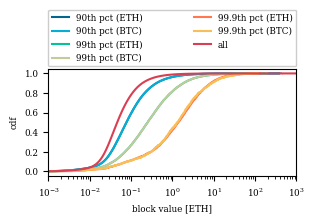

In [64]:
stat = "proportion" 
sns.ecdfplot(blockDataETHVol2['blockValueHFT'], stat=stat,label='90th pct (ETH)',color=Color.DARKBLUE.value)
sns.ecdfplot(blockDataETHVol2['blockValueHFT'], stat=stat,label='90th pct (BTC)',color=Color.LIGHTBLUE.value)
sns.ecdfplot(blockDataBTCVol21['blockValueHFT'], stat=stat,label='99th pct (ETH)',color=Color.GREEN.value)
sns.ecdfplot(blockDataBTCVol21['blockValueHFT'], stat=stat,label='99th pct (BTC)',color=Color.LIGHTGREEN.value)
sns.ecdfplot(blockDataETHVol22['blockValueHFT'], stat=stat,label='99.9th pct (ETH)',color=Color.ORANGE.value)
sns.ecdfplot(blockDataBTCVol22['blockValueHFT'], stat=stat,label='99.9th pct (BTC)',color=Color.YELLOW.value)
sns.ecdfplot(blockData2['blockValueHFT'], stat=stat,label='all',color=Color.RED.value)
plt.xlabel('block value [ETH]')
plt.ylabel('cdf')
ax = plt.gca()
plt.xscale('log')
plt.ylim(-0.05,1.05)
plt.xlim(0.001,1000)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.show()

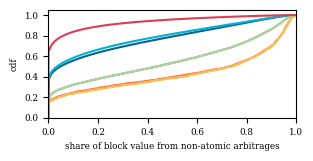

In [65]:
stat = "proportion" 
sns.ecdfplot(blockDataETHVol2['txValueHFT'], stat=stat,label='90th pct (ETH)',color=Color.DARKBLUE.value)
sns.ecdfplot(blockDataBTCVol2['txValueHFT'], stat=stat,label='90th pct (BTC)',color=Color.LIGHTBLUE.value)
sns.ecdfplot(blockDataBTCVol21['txValueHFT'], stat=stat,label='99th pct (ETH)',color=Color.GREEN.value)
sns.ecdfplot(blockDataBTCVol21['txValueHFT'], stat=stat,label='99th pct (BTC)',color=Color.LIGHTGREEN.value)
sns.ecdfplot(blockDataETHVol22['txValueHFT'], stat=stat,label='99.9th pct (ETH)',color=Color.ORANGE.value)
sns.ecdfplot(blockDataBTCVol22['txValueHFT'], stat=stat,label='99.9th pct (BTC)',color=Color.YELLOW.value)
sns.ecdfplot(blockData2['txValueHFT'], stat=stat,label='all',color=Color.RED.value)
plt.xlabel('share of block value from non-atomic arbitrages')
plt.ylabel('cdf')
plt.xlim(0,1)
plt.ylim(0,1.05)
ax = plt.gca()
plt.show()

## Non-Atomic Arbitrage Share by HFT Builders

In [66]:
plt.rcParams["figure.figsize"] = (3.7,2) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

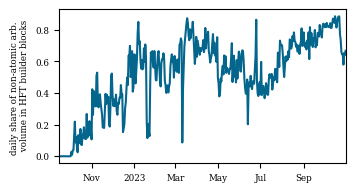

In [67]:
ax = plt.gca()

ax.plot((mergedData[mergedData['builderPubkey'].isin(HFTBuilder)].groupby('day').amountUSD.sum()/mergedData.groupby('day').amountUSD.sum()).fillna(0), label='beaverbot1',color=Color.DARKBLUE.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
plt.ylabel('daily share of non-atomic arb. \n volume in HFT builder blocks')
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

## Relationship Between Builders and Bots

In [68]:
matplotlib.rc('image', cmap='Blues')
matplotlib.rc('font', **font)

In [69]:
tempdf=mergedData.groupby(['recipient', 'builderPubkey']).amountUSD.sum().unstack(fill_value=0)
tempdf =tempdf[bigBuilders]
tempdf =tempdf.reindex(bigBots)
botsToBuilders = tempdf.div( tempdf.sum(axis=1), axis=0 )
buildersFromBots = tempdf.div( tempdf.sum(axis=0), axis=1 )
botsToBuilders = botsToBuilders.astype(float)
buildersFromBots = buildersFromBots.astype(float)

Share of non-atomic arbitrage transactions by bots send to builders.

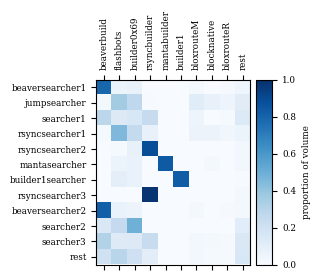

In [70]:
fig=plt.figure(figsize=(5.5,2.4)) 
ax = fig.add_subplot(111)
im = ax.matshow(botsToBuilders, vmin=0, vmax=1)
ax.set_xticks( np.arange(0,10,1))
ax.set_yticks( np.arange(0,12,1))
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar=plt.colorbar(im, cax=cax) 
ax.set_xticklabels(bigBuilders,rotation=90)
ax.set_yticklabels(bigBots)
cbar.ax.set_ylabel("proportion of volume", rotation = 90, va = "top")
plt.show()

Share of non-atomic arbitrage transactions in builder blocks by bots.

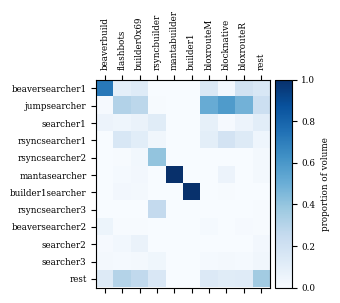

In [71]:
fig=plt.figure(figsize=(5.5,2.7)) 
ax = fig.add_subplot(111)
im = ax.matshow(buildersFromBots, vmin=0, vmax=1)
ax.set_xticks( np.arange(0,10,1))
ax.set_yticks( np.arange(0,12,1))
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar=plt.colorbar(im, cax=cax) 
ax.set_xticklabels(bigBuilders,rotation=90)
ax.set_yticklabels(bigBots)
cbar.ax.set_ylabel("proportion of volume", rotation = 90, va = "top")
plt.show()

### HFT Builders

In [72]:
plt.rcParams["figure.figsize"] = (3.2,1.8) 
font = {'family': 'serif', 'size': 6.3}
matplotlib.rc('font', **font)

In [73]:
blockPerBuilder=blockData.copy()
blockPerBuilder=blockPerBuilder.groupby(['day', 'builderPubkey']).size().unstack(fill_value=0)
blockPerBuilder['sum']=blockPerBuilder.sum(axis=1)
blockPerBuilder.iloc[:,:-1]=blockPerBuilder.iloc[:,:-1].div(blockPerBuilder.iloc[:,-1], axis=0)
blockPerBuilder['rest'] = blockPerBuilder.pop('rest')
blockPerBuilder=blockPerBuilder[bigBuilders]

In [74]:
blockPerBot.index = pd.to_datetime(blockPerBot.index)
blockPerBuilder.index = pd.to_datetime(blockPerBuilder.index)

Beaverbuild

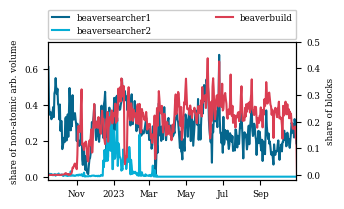

In [75]:
ax = plt.gca()

lns1=ax.plot(blockPerBot.index,blockPerBot.beaversearcher1, label='beaversearcher1',color=Color.DARKBLUE.value)
lns2=ax.plot(blockPerBot.index,blockPerBot.beaversearcher2, label='beaversearcher2',color=Color.LIGHTBLUE.value)


ax2 = ax.twinx()
lns3=ax2.plot(blockPerBuilder.index,blockPerBuilder.beaverbuild, label='beaverbuild',color=Color.RED.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
ax.set_ylabel('share of non-atomic arb. volume')
ax2.set_ylabel('share of blocks')
ax.set_ylim(-0.02,0.75)
ax2.set_ylim(-0.02,0.5)
# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [76]:
print(pearsonr((blockPerBot.loc[pd.to_datetime('2022-10-25'):pd.to_datetime('2023-10-31')].beaversearcher1+blockPerBot.loc[pd.to_datetime('2022-10-25'):pd.to_datetime('2023-10-31')].beaversearcher2).tolist(),blockPerBuilder.loc[pd.to_datetime('2022-10-25'):pd.to_datetime('2023-10-31')].beaverbuild.tolist()))

PearsonRResult(statistic=0.2383642620372856, pvalue=3.3336549158367957e-06)


In [77]:
blockData['builderProfit'] = (blockData['proposerfee']+blockData['coinbasetransfers']- blockData['proposerpayment'])
beaverData=blockData[blockData['builderPubkey']=='beaverbuild']
beaverData=beaverData.groupby('day').aggregate({'builderProfit':'sum'})
blockDataShort = blockData[(~(blockData['builderPubkey']=='beaverbuild'))& (blockData['builderPubkey']==blockData['builderPubkey'])]
blockDataShort=blockDataShort.groupby('day').aggregate({'builderProfit':'sum'})

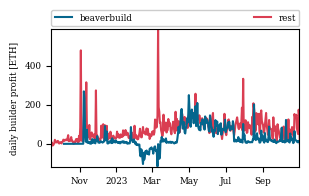

In [78]:
ax = plt.gca()
lns2=ax.plot(blockDataShort.index,blockDataShort.builderProfit, label='rest',color=Color.RED.value)
lns1=ax.plot(beaverData.index,beaverData.builderProfit, label='beaverbuild',color=Color.DARKBLUE.value)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
ax.set_ylabel('daily builder profit [ETH]')
ax.set_ylim(-120,590)

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

Mantabuilder

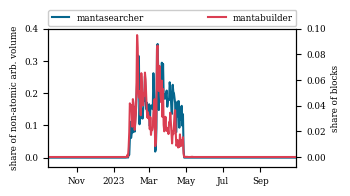

In [79]:
ax = plt.gca()

lns1=ax.plot(blockPerBot.index,blockPerBot.mantasearcher, label='mantasearcher',color=Color.DARKBLUE.value)


ax2 = ax.twinx()
lns2=ax2.plot(blockPerBuilder.index,blockPerBuilder.mantabuilder, label='mantabuilder',color=Color.RED.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
ax.set_ylabel('share of non-atomic arb. volume')
ax2.set_ylabel('share of blocks')
# added these three lines

ax.set_ylim(-0.03,0.4)
ax2.set_ylim(-0.008,0.1)
lns = lns1+lns2
labs = [l.get_label() for l in lns]
lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [80]:
print(pearsonr((blockPerBot.loc[pd.to_datetime('2023-01-23'):pd.to_datetime('2023-05-12')].mantasearcher).tolist(),blockPerBuilder.loc[pd.to_datetime('2023-01-23'):pd.to_datetime('2023-05-12')].mantabuilder.tolist()))

PearsonRResult(statistic=0.7394514210536594, pvalue=2.833699363586297e-20)


Rsyncbuilder

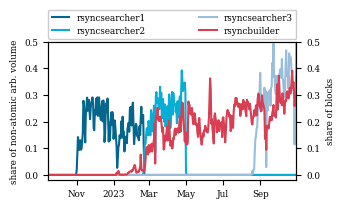

In [81]:
ax = plt.gca()

lns1=ax.plot(blockPerBot.index,blockPerBot.rsyncsearcher1, label='rsyncsearcher1',color=Color.DARKBLUE.value)
lns2=ax.plot(blockPerBot.index,blockPerBot.rsyncsearcher2, label='rsyncsearcher2',color=Color.LIGHTBLUE.value)
lns3=ax.plot(blockPerBot.index,blockPerBot.rsyncsearcher3, label='rsyncsearcher3',color='#9ABDDC')


ax2 = ax.twinx()
lns4=ax2.plot(blockPerBuilder.index,blockPerBuilder.rsyncbuilder, label='rsyncbuilder',color=Color.RED.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
ax.set_ylabel('share of non-atomic arb. volume')
ax2.set_ylabel('share of blocks')
# added these three lines
ax.set_ylim(-0.02,0.5)
ax2.set_ylim(-0.02,0.5)
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [82]:
print(pearsonr((blockPerBot.loc[pd.to_datetime('2023-02-17'):pd.to_datetime('2023-05-01')].rsyncsearcher2).tolist(),blockPerBuilder.loc[pd.to_datetime('2023-02-17'):pd.to_datetime('2023-05-01')].rsyncbuilder.tolist()))

PearsonRResult(statistic=0.8160521219105332, pvalue=8.218302594418674e-19)


In [83]:
print(pearsonr(blockPerBot.loc[pd.to_datetime('2023-08-18'):pd.to_datetime('2023-10-31')].rsyncsearcher3,blockPerBuilder.loc[pd.to_datetime('2023-08-18'):pd.to_datetime('2023-10-31')].rsyncbuilder.tolist()))

PearsonRResult(statistic=0.4914307774922636, pvalue=7.568202069538368e-06)


Builder 1

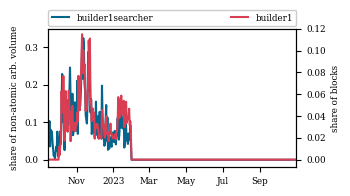

In [84]:
ax = plt.gca()

lns1=ax.plot(blockPerBot.index,blockPerBot.builder1searcher, label='builder1searcher',color=Color.DARKBLUE.value)


ax2 = ax.twinx()
lns2=ax2.plot(blockPerBuilder.index,blockPerBuilder.builder1, label='builder1',color=Color.RED.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
ax.set_ylabel('share of non-atomic arb. volume')
ax2.set_ylabel('share of blocks')
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.set_ylim(-0.02,0.35)
ax2.set_ylim(-0.007,0.12)

lgd = ax.legend(lns,labs,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=3, mode="expand", borderaxespad=0.)
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
plt.show()

In [85]:
print(pearsonr((blockPerBot.loc[pd.to_datetime('2022-09-27'):pd.to_datetime('2023-01-30')].builder1searcher).tolist(),blockPerBuilder.loc[pd.to_datetime('2022-09-27'):pd.to_datetime('2023-01-30')].builder1.tolist()))

PearsonRResult(statistic=0.7720790597401369, pvalue=3.5724031194653594e-26)


## MEV

Daily number of MEV transactions

In [86]:
mevdata = pd.concat([mevdata.reset_index(),mergedData[['block','day','txValue']].groupby('day').aggregate({'block':'count','txValue':'sum'}).rename(columns={'block':'nonarbcount','txValue':'nonaarbpayment'}).reset_index()],axis=1)

In [87]:
mevdata.index = mevdata.day

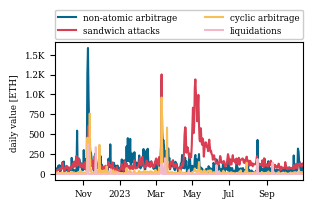

In [88]:
ax = plt.gca()

ax.plot(mevdata.nonaarbpayment, label='non-atomic arbitrage',color=Color.DARKBLUE.value)
ax.plot(mevdata.sandwichpayment, label='sandwich attacks',color=Color.RED.value)
ax.plot(mevdata.arbpayment, label='cyclic arbitrage',color=Color.YELLOW.value)
ax.plot(mevdata.liquidpayment, label='liquidations',color=Color.PINK.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,3))
ax.yaxis.set_major_formatter(currency_format)   
lo = Labeloffset(ax, label=r"daily value [ETH]", axis="y")
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('plots/MEVtypespayment.pdf', bbox_inches='tight',pad_inches=0.01)

In [89]:
print("Average daily non-atomic arbitrage value: ",mevdata.nonaarbpayment.mean(), " ETH")
print("Average daily sandwich attack value: ",mevdata.sandwichpayment.mean(), " ETH")
print("Average daily cyclic arbitrage value: ",mevdata.arbpayment.mean(), " ETH")
print("Average daily liquidation value: ",mevdata.liquidpayment.mean(), " ETH")

Average daily non-atomic arbitrage value:  112.03523430064563  ETH
Average daily sandwich attack value:  161.2256187054543  ETH
Average daily cyclic arbitrage value:  25.542443677559884  ETH
Average daily liquidation value:  4.937236307335055  ETH


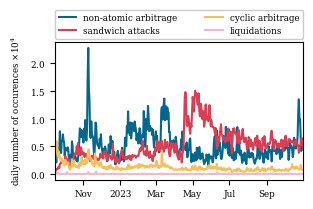

In [90]:
ax = plt.gca()

ax.plot(mevdata.nonarbcount, label='non-atomic arbitrage',color=Color.DARKBLUE.value)
ax.plot(mevdata.sandwichcount, label='sandwich attacks',color=Color.RED.value)
ax.plot(mevdata.arbcount, label='cyclic arbitrage',color=Color.YELLOW.value)
ax.plot(mevdata.liquidcount, label='liquidations',color=Color.PINK.value)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)   
ax.set_xlabel('')
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3,3))
ax.yaxis.set_major_formatter(formatter)   
lo = Labeloffset(ax, label=r"daily number of occurences", axis="y")
ax.set_xlim([pd.to_datetime('2022-09-15'), pd.to_datetime('2023-10-31')])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [91]:
print("Average daily non-atomic arbitrage number: ",mevdata.nonarbcount.mean())
print("Average daily sandwich attack number: ",mevdata.sandwichcount.mean())
print("Average daily cyclic arbitrage number: ",mevdata.arbcount.mean())
print("Average daily liquidation number: ",mevdata.liquidcount.mean())

Average daily non-atomic arbitrage number:  5216.495145631068
Average daily sandwich attack number:  5219.402912621359
Average daily cyclic arbitrage number:  1245.0
Average daily liquidation number:  14.439320388349515


MEV transactions by HFT builders

In [92]:
arbData = {}
for i in ['beaverbuild','rsyncbuilder','builder1','mantabuilder']:
    arbData[i]={}
    arbData[i]['sandwich'] = blockData[blockData['builderPubkey']==i].sandwich.sum()/blockData[blockData['builderPubkey']==i].size
    arbData[i]['arb'] = blockData[blockData['builderPubkey']==i].arb.sum()/blockData[blockData['builderPubkey']==i].size

In [93]:
tablearbData=pd.DataFrame.from_dict(arbData, orient='index').T
print(tablearbData.to_latex(index=True,float_format="%.3f"))   

\begin{tabular}{lrrrr}
\toprule
 & beaverbuild & rsyncbuilder & builder1 & mantabuilder \\
\midrule
sandwich & 0.045 & 0.047 & 0.000 & 0.001 \\
arb & 0.008 & 0.006 & 0.003 & 0.002 \\
\bottomrule
\end{tabular}

